Повторение препроцессинга из этой папиры[https://sci-hub.se/10.1016/j.irbm.2019.09.003]:
"The ECG signal from PTB-Database is down sampled to a sampling frequency f s = 250 Hz, since most of the obligatory information is covered in this range. The down sampled ECG signal is segmented into short ECG segments of 3.072 seconds. The downsampled and segmented signal is passed through a 2-stage median filter to remove the baseline wander. This is followed by a Savitzky-Golay (SG) smoothing filter. Window width of the two stages of median filter and SG filter’s order and frame size is selected as described in [34–36]. Say, ECG signal after this preprocessing stage be z[n]."

ЧИТАТЬ ДАННЫЕ ПРОЧЕСТЬ

In [2]:
import pandas as pd
import numpy as np

gts_df = pd.read_csv("./train/train_gts.csv")
meta_df = pd.read_csv("./train/train_meta.csv")

df = pd.merge(gts_df, meta_df, on='record_name')
df

,record_name,myocard,ecg_id,patient_id,age,sex,height,weight,nurse,site,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
0,00669_hr,0,669,2229.0,37.0,1,163.0,95.0,10.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/00000/00669_lr,records500/00000/00669_hr,1
1,00209_hr,0,209,14751.0,37.0,0,NaN,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00209_lr,records500/00000/00209_hr,1
2,00777_hr,0,777,17731.0,55.0,1,NaN,57.0,0.0,0.0,...,", V3",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00777_lr,records500/00000/00777_hr,1
3,01394_hr,0,1394,11281.0,65.0,1,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/01000/01394_lr,records500/01000/01394_hr,1
4,01618_hr,0,1618,17507.0,39.0,1,NaN,70.0,0.0,0.0,...,", I-AVF",", alles,",NaN,NaN,NaN,NaN,10,records100/01000/01618_lr,records500/01000/01618_hr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,20864_hr,0,20864,17444.0,69.0,0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/20000/20864_lr,records500/20000/20864_hr,3
2097,20967_hr,0,20967,13969.0,68.0,1,NaN,NaN,1.0,2.0,...,NaN,", alles,",NaN,NaN,NaN,NaN,6,records100/20000/20967_lr,records500/20000/20967_hr,3
2098,21744_hr,0,21744,20990.0,37.0,1,NaN,NaN,0.0,0.0,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,2,records100/21000/21744_lr,records500/21000/21744_hr,3
2099,03465_hr,0,3465,1354.0,76.0,0,168.0,77.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/03000/03465_lr,records500/03000/03465_hr,3


In [3]:
import os
import  matplotlib.pyplot as plt


def load_record(record_name, prefix):
    path = os.path.join(prefix, record_name + ".npy")    
    record = np.load(path)
    return record

def print_record(x, y):
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.plot(x, y)  # Plot some data on the axes.

Downsampling
оригинальная дата - 500 hz
в папире предлагают 250 hz

In [4]:
from scipy.signal import decimate 
from scipy.signal import medfilt 
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
import pywt

def downsample(record):
    # downsample from 500 to 250 hz
    return decimate(record, 2) 

Разделить на сегменты
Не понял откуда в изначальной папире появилось 3.072 секунды. Делю каждый сигнал на сегменты по 2.5 секунды.
понял, 3.072 секунды, чтобы было 768 элементов в сегменте, чтобы вейвлеты работали.

In [5]:
meow = downsample(load_record("00009_hr", './train/'))
def segmentation(record, hz=250, segment_time=3.072):
    """
        hz -  герц у сигнала
        segment_time - количество секунд в сегменте
        record.shape = [12,2500]
    """
    # так как 2500 не делится на 768 укорачиваю последнюю axis, так чтобы делилось.
    segment_len = int(hz*segment_time)
    chuncks_num = len(record[0])//segment_len
    record = record[:,:int(chuncks_num*segment_len)]

    result = np.asarray(np.split(record,chuncks_num, axis=-1))
    result = np.reshape(result, (12, result.shape[0], result.shape[-1])) # by default shape is 12,3,768
    return result


In [6]:
segmentation(meow).shape 

(12, 3, 768)

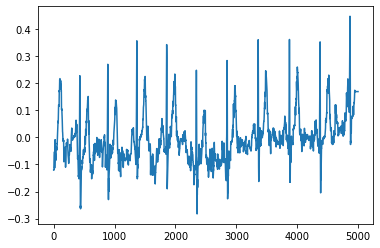

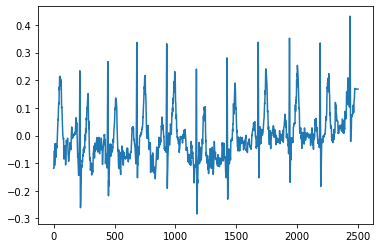

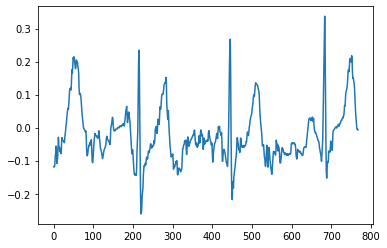

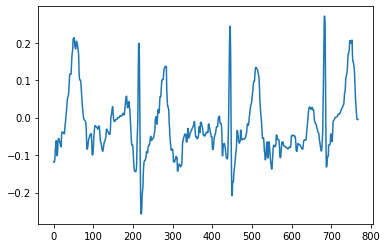

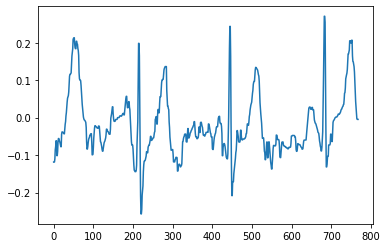

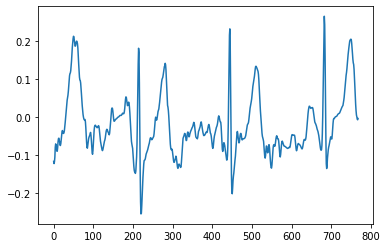

In [7]:
test_record = load_record("00009_hr", './train/')
print_record([x for x in range(len(test_record[0]))], test_record[0])
test_record = downsample(test_record)
print_record([x for x in range(len(test_record[0]))], test_record[0])
test_record = segmentation(test_record)
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0])

test_record = medfilt(test_record,kernel_size=[1,1,3])
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0])

test_record = medfilt(test_record,kernel_size=[1,1,3])
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0])


test_record = savgol_filter(test_record, window_length = 8, polyorder=3)
print_record([x for x in range(len(test_record[0][0]))], test_record[0][0])


In [9]:
# 6 - количество уровней(каждый уровень типа разное приближение); 2 - coeficients, frequencies; 12,3,768 - 12 экг каналов поделенные на 3 сегмента по 768
meow = np.asarray(pywt.swt(test_record, wavelet='db5', level=6, axis=-1))
meow.shape 

(6, 2, 12, 3, 768)

In [8]:
def pipeline(record_name, prefix):

    record = load_record(record_name, prefix)
    record = downsample(record)
    record = segmentation(record)
    record = medfilt(test_record, kernel_size=[1,1,3]) #stage 1
    record = medfilt(test_record, kernel_size=[1,1,3]) #stage 2
    record = savgol_filter(test_record, window_length = 8, polyorder=3) 

    record = np.asarray(pywt.swt(test_record, wavelet='db5', level=6, axis=-1))

    return record

https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/ здесь хуячат вейвлеты с снн, надо тоже. Надо наверное будет выбрать один экг лид и пихать.

In [10]:
meow[:,:,0,1,:]

array([[[-0.767544  , -0.7636024 , -0.7598207 , ..., -0.78021467,
         -0.7758624 , -0.7716302 ],
        [ 0.9558093 ,  0.98546195,  1.0082382 , ...,  0.8276765 ,
          0.8766499 ,  0.9194576 ]],

       [[ 0.31291467,  0.28809604,  0.25962442, ...,  0.36462077,
          0.35122517,  0.33396447],
        [ 0.2923718 ,  0.3103618 ,  0.3239361 , ...,  0.21317902,
          0.24360225,  0.2700483 ]],

       [[-0.06519223, -0.0370139 , -0.00316871, ..., -0.12171979,
         -0.10679311, -0.08812552],
        [ 0.11068235,  0.10528677,  0.09981459, ...,  0.11675543,
          0.11775403,  0.11530245]],

       [[ 0.64365816,  0.6552274 ,  0.65688396, ...,  0.572702  ,
          0.6003293 ,  0.6241482 ],
        [ 0.00281299, -0.00254801, -0.00168169, ...,  0.04574524,
          0.0354066 ,  0.01683513]],

       [[ 0.21644543,  0.18249168,  0.17186429, ...,  0.38205895,
          0.3290412 ,  0.2716374 ],
        [ 0.00787187, -0.02554237, -0.03529477, ...,  0.03276221,
        